In [20]:
import numpy as np
import pickle

from scipy.stats import spearmanr
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

# load explanations

In [21]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# 1a. calculate rank correlation matrices + plot heatmaps

In [22]:
def calc_rank_corr_two_methods(attr1, attr2, k):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #calculate feature ranks, top k features
    ranks1 = np.argsort(-np.abs(attr1), axis=1)[:, 0:k]
    ranks2 = np.argsort(-np.abs(attr2), axis=1)[:, 0:k]

    #calculate rank correlation for each data point
    #https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable
    corrs = []
    for row in range(ranks1.shape[0]):
        rho, _ = spearmanr(ranks1[row, :], ranks2[row, :])
        corrs.append(rho)
        
    return np.array(corrs) #rank correlations for each datapoint




In [23]:
def calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs, k):
    
    #initiate correlation matrix
    num_expl_methods = len(expl_methods_attrs)
    corr_matrix = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill correlation matrix with average rank correlation
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        #print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        corrs = calc_rank_corr_two_methods(expl_methods_attrs[a], expl_methods_attrs[b], k) #rank correlations for each datapoint
        corr_matrix[a, b] = np.mean(corrs) #average rank correlation
        corr_matrix[b, a] = corr_matrix[a, b]
        
    return corr_matrix
    
    

In [24]:
def plot_corr_matrix(corr_matrix, plot_path, 
                     labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, 
                vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels, annot=True, fmt='.4f',
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    plt.savefig(plot_path, facecolor='white', transparent=False)

In [25]:
#combine both functions
def rank_correlation_analysis(expl_methods_names, expl_methods_attrs, k, plot_path, 
                              labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    corr_matrix = calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs, k)
    plot_corr_matrix(corr_matrix, plot_path, labels)
    
    return corr_matrix

# 1b. rank corr. : heatmaps, results, evaluate all k's

### NN + logistic

----------- calculating rank correlation for nn, k=2
[[ 1.   -0.28  0.38 -0.41 -0.41  0.38]
 [-0.28  1.   -0.66  0.63  0.63 -0.66]
 [ 0.38 -0.66  1.   -0.97 -0.97  1.  ]
 [-0.41  0.63 -0.97  1.    1.   -0.97]
 [-0.41  0.63 -0.97  1.    1.   -0.97]
 [ 0.38 -0.66  1.   -0.97 -0.97  1.  ]]
----------- calculating rank correlation for nn, k=3
[[ 1.     -0.1375  0.22   -0.24   -0.225   0.165 ]
 [-0.1375  1.     -0.305   0.4575  0.47   -0.2675]
 [ 0.22   -0.305   1.     -0.505  -0.4775  0.845 ]
 [-0.24    0.4575 -0.505   1.      0.9525 -0.5275]
 [-0.225   0.47   -0.4775  0.9525  1.     -0.545 ]
 [ 0.165  -0.2675  0.845  -0.5275 -0.545   1.    ]]
----------- calculating rank correlation for nn, k=4
[[ 1.    -0.038  0.149 -0.173 -0.156  0.131]
 [-0.038  1.    -0.096  0.304  0.308 -0.083]
 [ 0.149 -0.096  1.    -0.184 -0.161  0.851]
 [-0.173  0.304 -0.184  1.     0.94  -0.182]
 [-0.156  0.308 -0.161  0.94   1.    -0.193]
 [ 0.131 -0.083  0.851 -0.182 -0.193  1.   ]]
----------- calculating rank

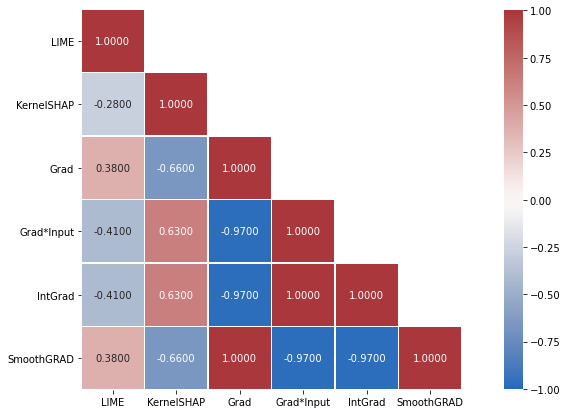

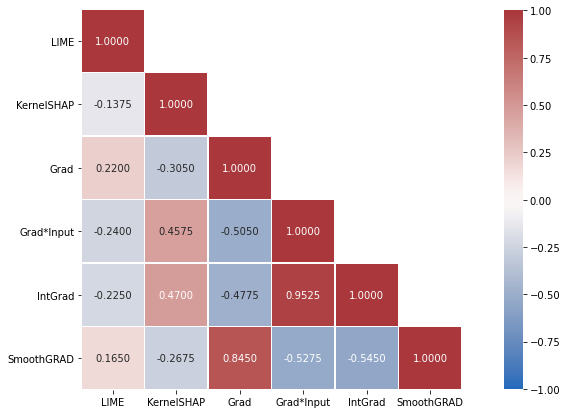

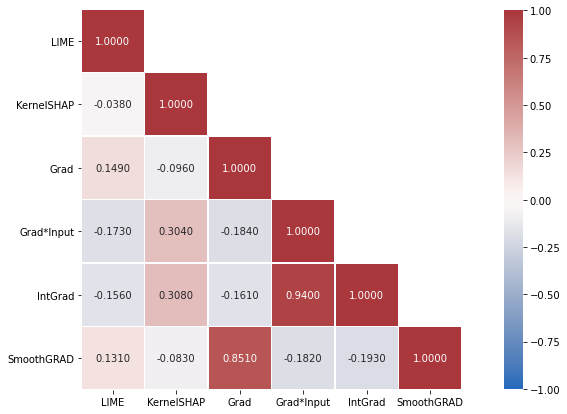

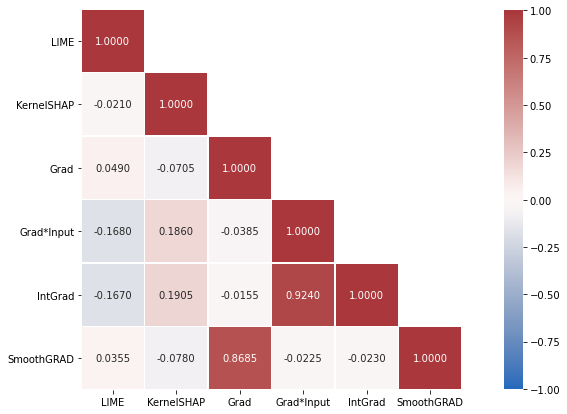

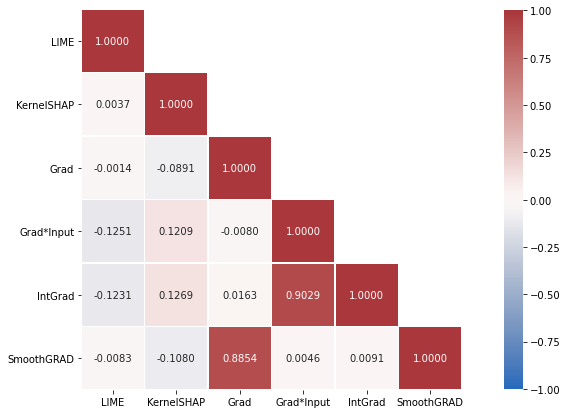

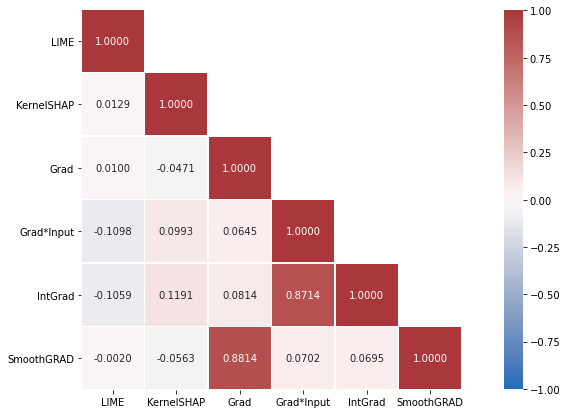

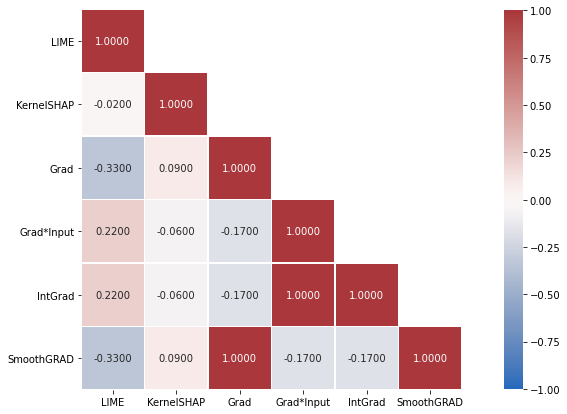

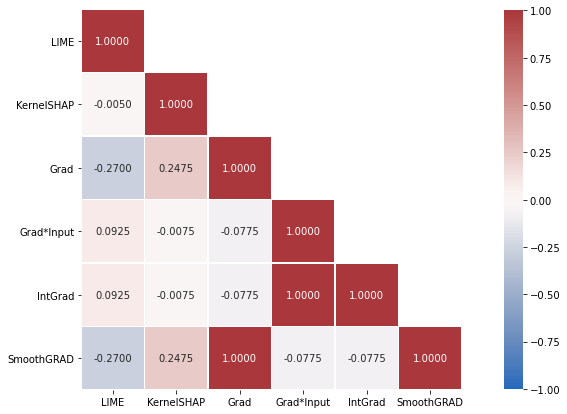

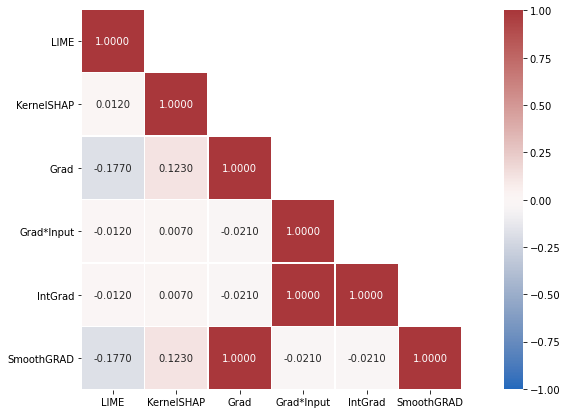

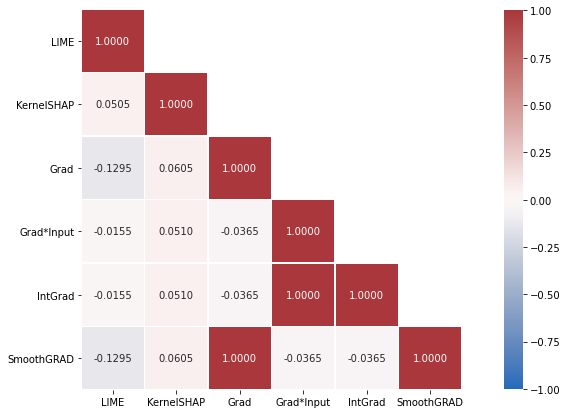

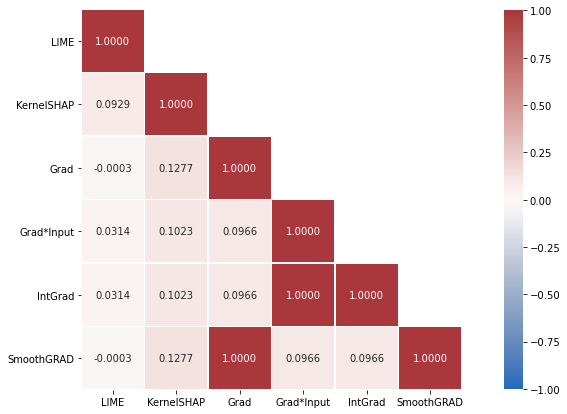

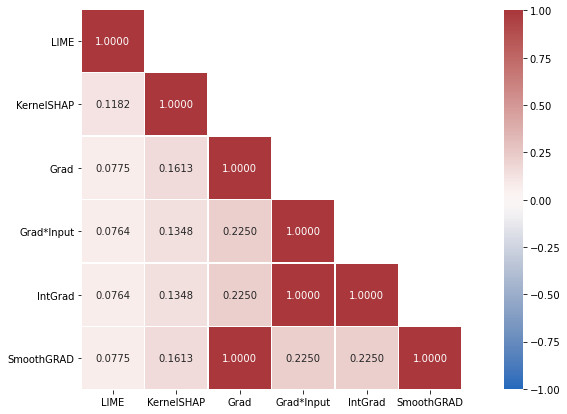

In [26]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
max_k=7

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    for k_i in range(2, max_k+1):
        print(f'----------- calculating rank correlation for {m}, k={k_i}')
        plot_path=f'figures/rank_corr_{m}_k{k_i}.png'
        corr_matrix = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, k=k_i, plot_path=plot_path)
        print(corr_matrix)

### RF + GB

----------- calculating rank correlation for rf, k=2
[[1.  0.5]
 [0.5 1. ]]
----------- calculating rank correlation for rf, k=3
[[1.   0.44]
 [0.44 1.  ]]
----------- calculating rank correlation for rf, k=4
[[1.    0.439]
 [0.439 1.   ]]
----------- calculating rank correlation for rf, k=5
[[1.    0.417]
 [0.417 1.   ]]
----------- calculating rank correlation for rf, k=6
[[1.         0.36485714]
 [0.36485714 1.        ]]
----------- calculating rank correlation for rf, k=7
[[1.         0.32410714]
 [0.32410714 1.        ]]
----------- calculating rank correlation for gb, k=2
[[1.   0.46]
 [0.46 1.  ]]
----------- calculating rank correlation for gb, k=3
[[1.     0.3625]
 [0.3625 1.    ]]
----------- calculating rank correlation for gb, k=4
[[1.    0.287]
 [0.287 1.   ]]
----------- calculating rank correlation for gb, k=5
[[1.    0.237]
 [0.237 1.   ]]
----------- calculating rank correlation for gb, k=6
[[1.         0.20828571]
 [0.20828571 1.        ]]
----------- calculating rank

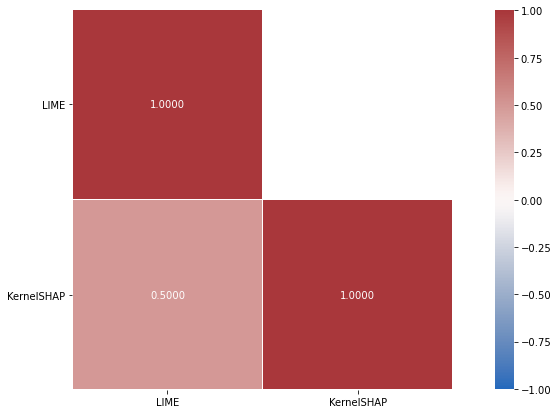

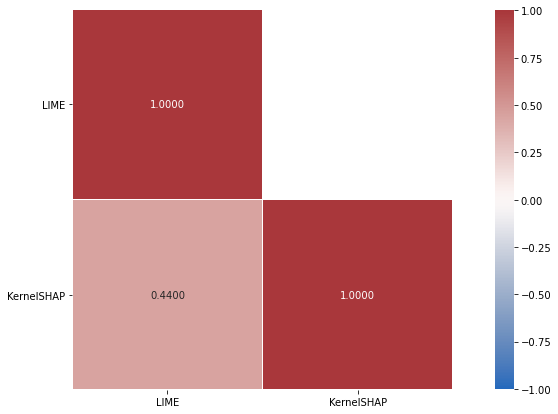

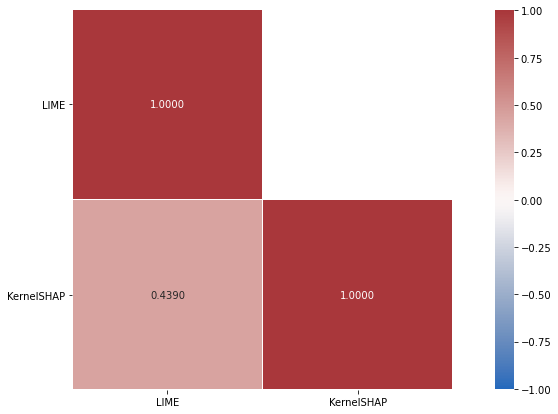

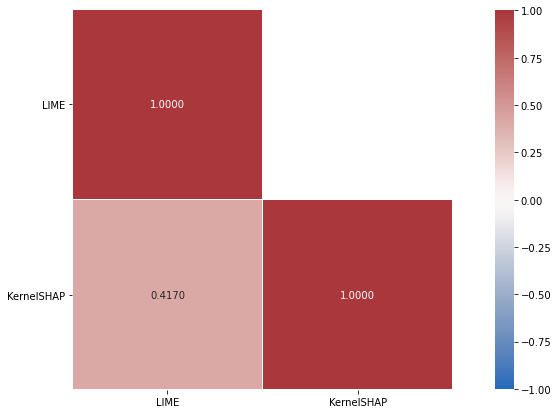

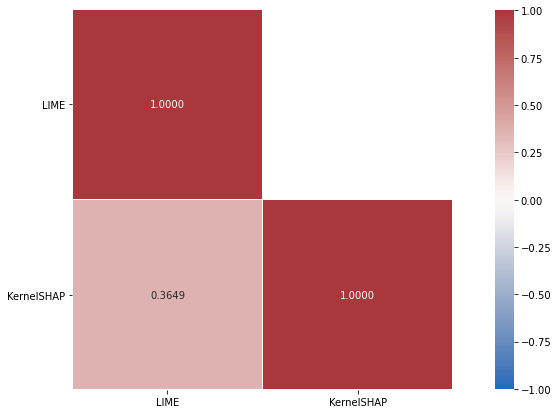

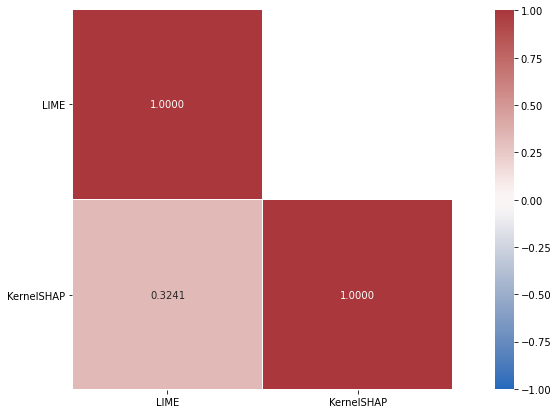

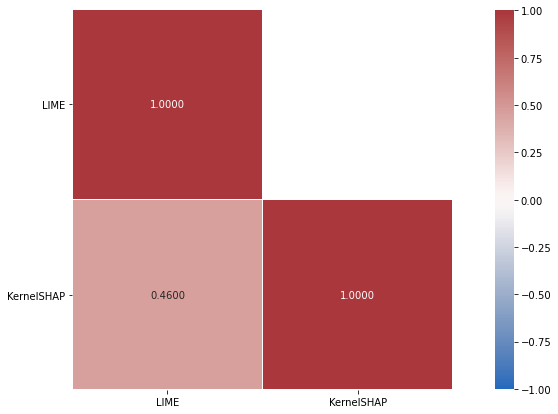

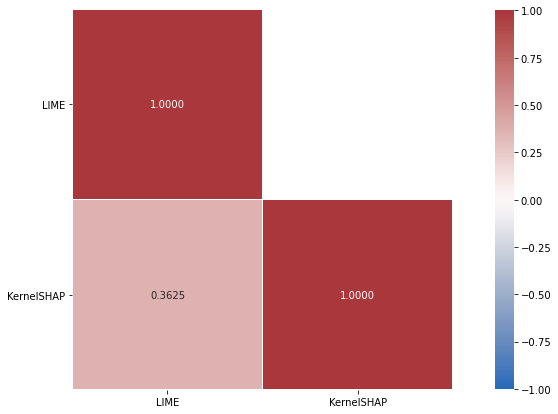

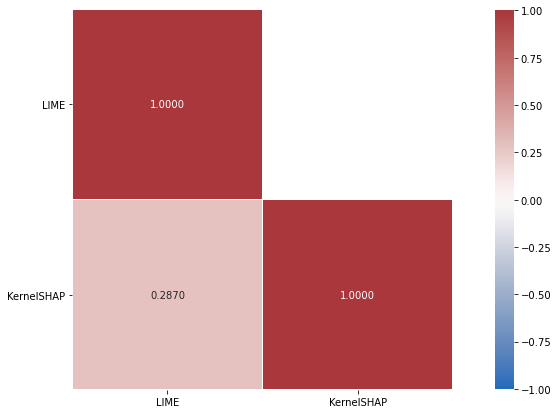

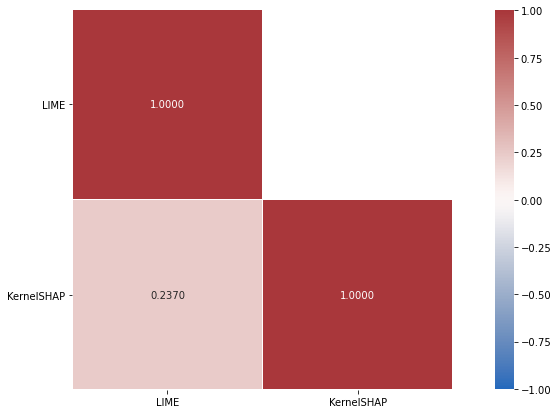

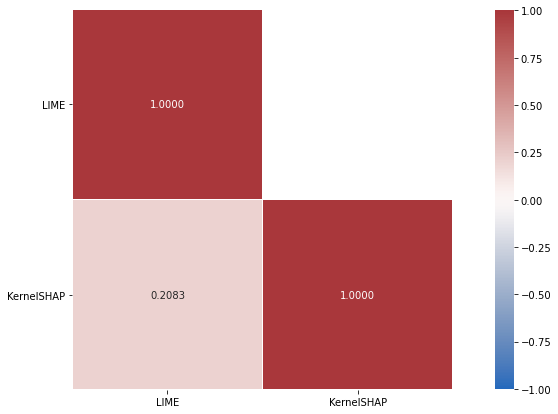

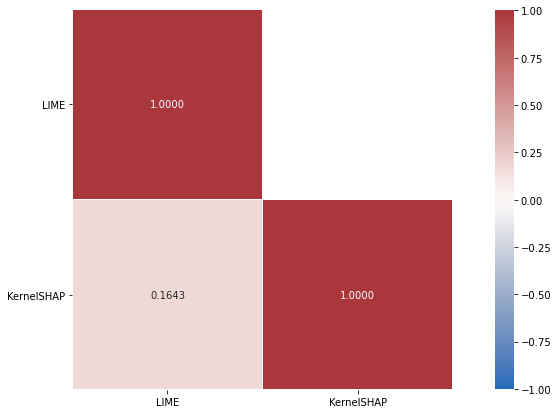

In [27]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
max_k=7


for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    for k_i in range(2, max_k+1):
        print(f'----------- calculating rank correlation for {m}, k={k_i}')
        plot_path=f'figures/rank_corr_{m}_k{k_i}.png'
        corr_matrix = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, k=k_i, 
                                              plot_path=plot_path, labels=['LIME', 'KernelSHAP'])
        print(corr_matrix)

# 2a. calculate rank correlation for barplots --> by k

In [28]:
#calculate topk agreement, all methods
def calc_rank_corr_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks):
    #initiate matrix
    num_expl_methods = len(expl_methods_attrs)
    
    #fill dict with pairwise rank corr. distribution
    rank_corr_dict = {}
    for a, b in itertools.combinations(range(num_expl_methods), 2):
        rank_corr_list = []
        for k in ks:
            rank_corr = calc_rank_corr_two_methods(expl_methods_attrs[a], expl_methods_attrs[b], k)
            rank_corr_list.append(rank_corr)
        rank_corr_dict[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = rank_corr_list
            
    return rank_corr_dict



In [29]:
def plot_rank_corr_boxplots(expl_methods_names, expl_methods_attrs, ks, plot_path):
    #calculate values for plotting
    metrics_dict = calc_rank_corr_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks)

    #plot
    fig, axes = plt.subplots(3, 5, figsize =(20, 8))
    for i, ax in enumerate(axes.flat):
        title, metric_values = list(metrics_dict.items())[i]
        sns.boxplot(data=metric_values, ax=ax, color='cornflowerblue')
        ax.set_xticklabels(ks, rotation=0)
        ax.set(xlabel='k', ylabel='Rank correlation', title=title)
    fig.tight_layout()
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')

# 2b. boxplots by k

### NN + logistic

top k analysis: nn, k=[2, 3, 4, 5, 6, 7]
top k analysis: nn_logistic, k=[2, 3, 4, 5, 6, 7]


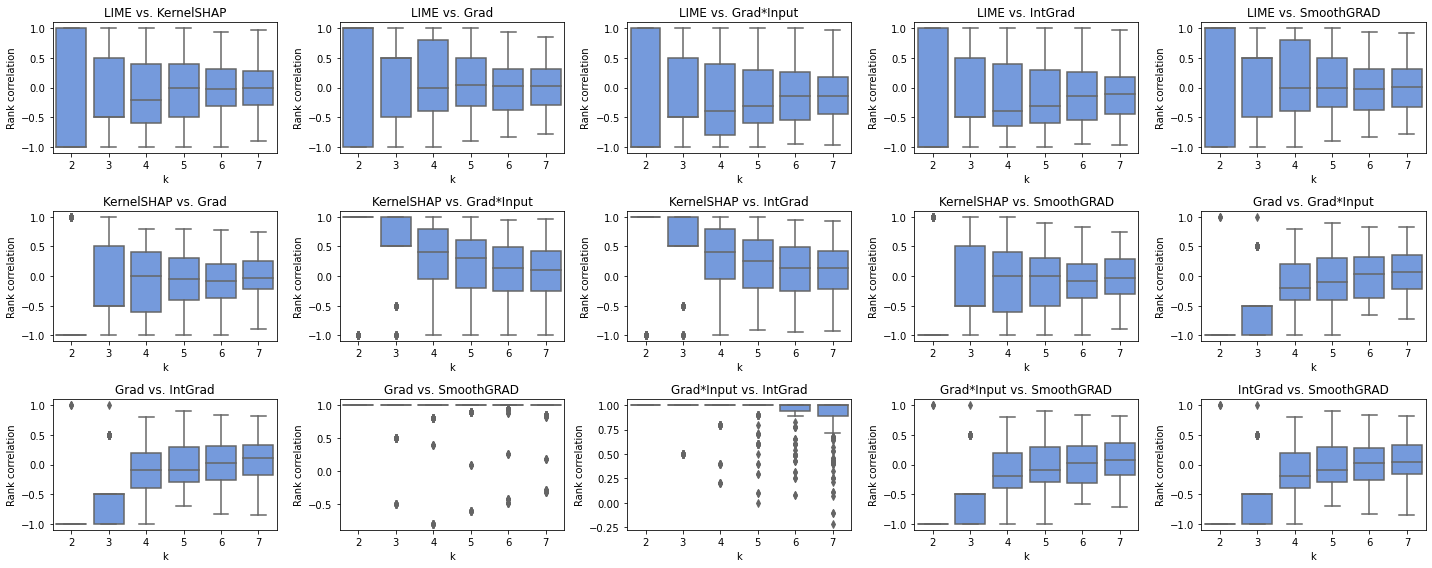

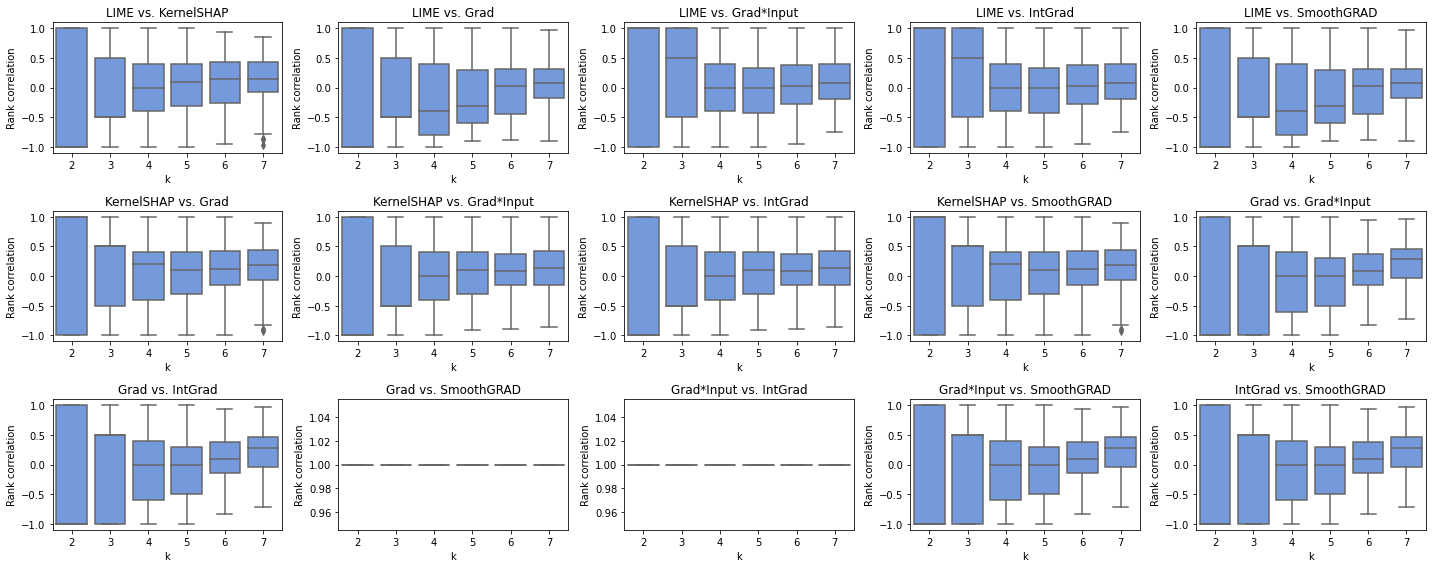

In [30]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
ks=[2, 3, 4, 5, 6, 7]

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    
    print(f'top k analysis: {m}, k={ks}')
    plot_path=f'figures/rank_corr_boxplot_by_k_{m}.png'
    plot_rank_corr_boxplots(expl_methods_names, expl_methods_attrs, ks, plot_path)


### RF + GB

top k analysis: rf, k=[2, 3, 4, 5, 6, 7]
top k analysis: gb, k=[2, 3, 4, 5, 6, 7]


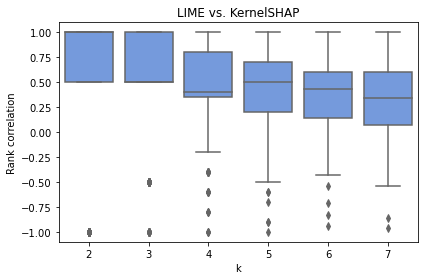

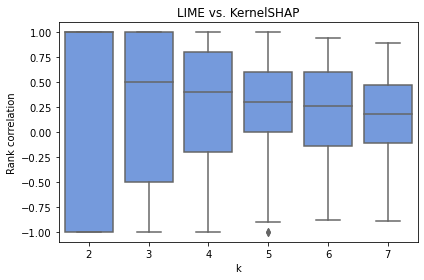

In [31]:
expl_methods_names = {0: 'LIME',
                      1: 'KernelSHAP'}
ks=[2, 3, 4, 5, 6, 7]

for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    
    print(f'top k analysis: {m}, k={ks}')

    #calculate values for plotting
    metrics_dict = calc_rank_corr_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks)

    #plot
    fig, axes = plt.subplots(1, 1, figsize =(6, 4))
    title, metric_values = list(metrics_dict.items())[0]
    sns.boxplot(data=metric_values, ax=axes, color='cornflowerblue')
    axes.set_xticklabels(ks, rotation=0)
    axes.set(xlabel='k', ylabel='Rank correlation', title=title)
    fig.tight_layout()
    plot_path=f'figures/rank_corr_boxplot_by_k_{m}.png'
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')



# 3a. calculate rank correlation for barplots --> by method

In [32]:
def plot_rank_corr_boxplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path):
    #function
    fig, axes = plt.subplots(1, 3, figsize =(18, 3))

    for i, k in enumerate(ks):
        #calculate rank corr
        metrics_dict = calc_rank_corr_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks=[k])
        #plot
        sns.boxplot(data=list(metrics_dict.values()), color='cornflowerblue', ax=axes[i])
        axes[i].set(xlabel='Method pair', ylabel='Rank correlation', title=f'k = {k}')       
        xlabels =list(metrics_dict.keys())
        axes[i].set_xticklabels(xlabels, rotation=0 if len(xlabels)==1 else 90) 

    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')

# 3b. boxplots by method

### NN + logistic

top k analysis: nn, k=[3, 5, 7]
top k analysis: nn_logistic, k=[3, 5, 7]


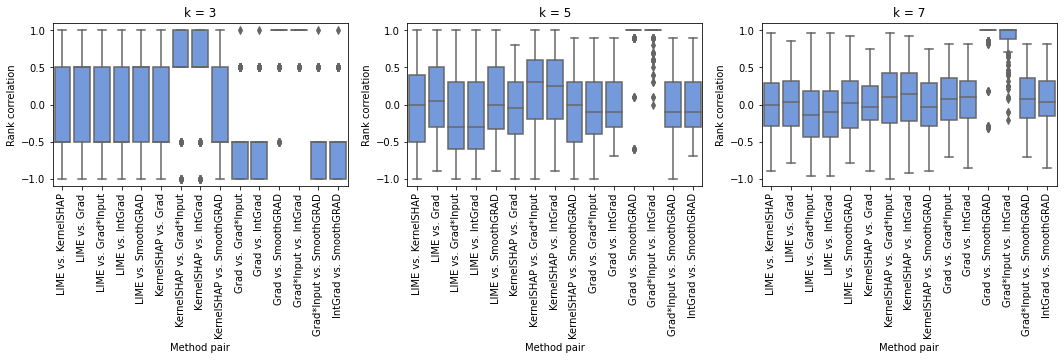

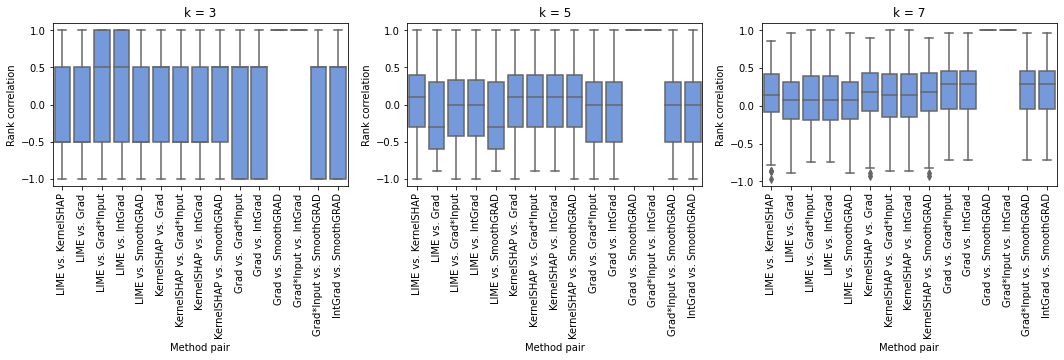

In [33]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
ks=[3, 5, 7]

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    
    print(f'top k analysis: {m}, k={ks}')
    plot_path=f'figures/rank_corr_boxplot_by_method_{m}.png'
    plot_rank_corr_boxplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path)


### RF + GB

top k analysis: rf, k=[3, 5, 7]
top k analysis: gb, k=[3, 5, 7]


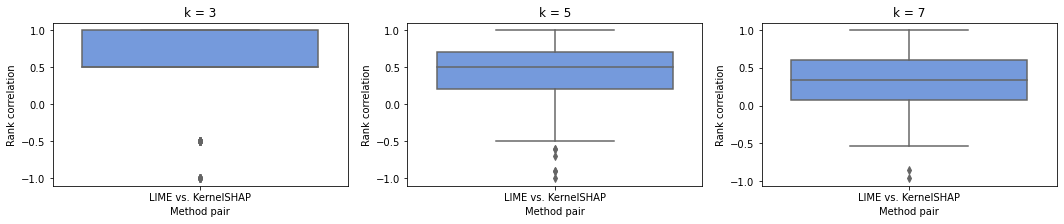

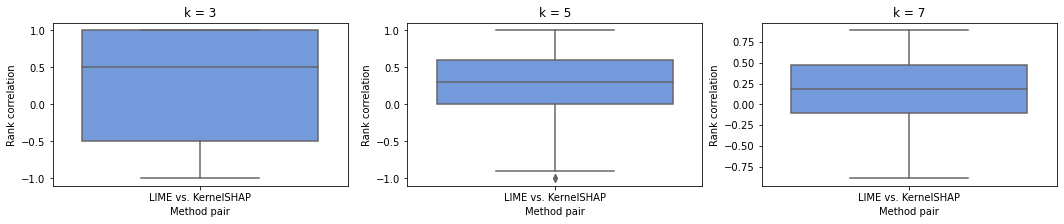

In [34]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
ks=[3, 5, 7]

for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    
    print(f'top k analysis: {m}, k={ks}')
    plot_path=f'figures/rank_corr_boxplot_by_method_{m}.png'
    plot_rank_corr_boxplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path)
